In [53]:
def get_no_cross_attn_size(row, encdec):
    emb_layer = row["source_vocab_size"] * row["embedding_size"]
    pos_emb = row["max_target_length"] * row["embedding_size"]
#     qkv_size = row["embedding_size"] / row["source_attention_heads"]
#     self_attn = row["embedding_size"] * qkv_size * row["source_attention_heads"] * 3
    # qkv matrices + bias * 3 for q, k, v
    self_attn = ((row["embedding_size"] ** 2) + row["embedding_size"]) * 3
    # projection after attn_head concat
    self_attn += ((row["embedding_size"] ** 2) + row["embedding_size"])
    self_attn *= row[f"{encdec}_layers"]
    # FFN + bias
    ffn = (row["embedding_size"] * row["hidden_size"] * 2) + row["embedding_size"] + row["hidden_size"]
    ffn *= row[f"{encdec}_layers"]
    # layer norms
    lnorms = 4 * row["embedding_size"]
    lnorms *= row[f"{encdec}_layers"]
    out_layer = row["target_vocab_size"] * row["embedding_size"] + row["embedding_size"]
    return emb_layer + pos_emb + self_attn + ffn + lnorms + out_layer

def compute_num_params(row):
    if row["arch_name"] == "decoder-only":
        return get_no_cross_attn_size(row, "decoder")
    else:
        # enc-dec + cross attention in the dec
        cross = ((row["embedding_size"] ** 2) + row["embedding_size"]) * 3
        # projection after attn_head concat
        cross += ((row["embedding_size"] ** 2))
        cross *= row[f"decoder_layers"]
        return get_no_cross_attn_size(row, "encoder") + get_no_cross_attn_size(row, "decoder") + cross
    

In [73]:
import pandas as pd
from collections import Counter

df = pd.read_csv("data/2017-decoder-only-deu-sweep.csv")
df["arch_name"] = "decoder-only"
# Ignore single attention head case
df = df.loc[df["source_attention_heads"] > 1]
df["params"] = df.apply(compute_num_params, axis=1)
print(len(set(df["Name"])))
df.sort_values(by="val_accuracy.max", ascending=False).head(10)

1


,Name,val_accuracy.max,hidden_size,embedding_size,decoder_layers,source_attention_heads,scheduler_kwargs/warmup_steps,State,Notes,User,...,target_vocab_size,teacher_forcing,val_out,epoch,lr-Adam,train_loss,trainer/global_step,val_loss,arch_name,params
62,german-train-high,0.922,1024,512,4,8,2000,finished,-,adamits,...,71,True,validation_preds,799,0.000316,0.751071,19999,0.874121,decoder-only,8560128
68,german-train-high,0.922,1024,512,8,4,2000,finished,-,adamits,...,71,True,validation_preds,799,0.000316,0.751476,19999,0.886847,decoder-only,16971264
186,german-train-high,0.918,256,512,8,4,2000,finished,-,adamits,...,71,True,validation_preds,799,0.000316,0.755550,19999,0.887725,decoder-only,10673664
23,german-train-high,0.917,1024,512,4,8,4000,finished,-,adamits,...,71,True,validation_preds,799,0.000447,0.753757,19999,0.883425,decoder-only,8560128
220,german-train-high,0.917,128,512,4,8,2000,finished,-,adamits,...,71,True,validation_preds,799,0.000316,0.758458,19999,0.871862,decoder-only,4886528
116,german-train-high,0.917,512,512,4,8,4000,finished,-,adamits,...,71,True,validation_preds,799,0.000447,0.755597,19999,0.891702,decoder-only,6460928
29,german-train-high,0.917,1024,256,8,2,4000,finished,-,adamits,...,71,True,validation_preds,799,0.000447,0.760794,19999,0.896809,decoder-only,6392576
21,german-train-high,0.916,1024,512,8,8,2000,finished,-,adamits,...,71,True,validation_preds,799,0.000316,0.749125,19999,0.891482,decoder-only,16971264
212,german-train-high,0.916,256,256,8,2,2000,finished,-,adamits,...,71,True,validation_preds,799,0.000316,0.769561,19999,0.901334,decoder-only,3240704
81,german-train-high,0.916,512,512,8,8,4000,finished,-,adamits,...,71,True,validation_preds,799,0.000447,0.754282,19999,0.929596,decoder-only,12772864


In [55]:
df.loc[
    (df["decoder_layers"] == 8) &
    (df["source_attention_heads"] == 8) &
    (df["hidden_size"] == 1024)
]

,Name,val_accuracy.max,hidden_size,embedding_size,decoder_layers,source_attention_heads,scheduler_kwargs/warmup_steps,State,Notes,User,...,target_vocab_size,teacher_forcing,val_out,epoch,lr-Adam,train_loss,trainer/global_step,val_loss,arch_name,params
2,german-train-high,0.909,1024,512,8,8,4000,finished,-,adamits,...,71,True,validation_preds,799,0.000447,0.753194,19999,0.919391,decoder-only,16971264
5,german-train-high,0.540,1024,64,8,8,4000,finished,-,adamits,...,71,True,validation_preds,799,0.000447,0.962376,19999,2.150249,decoder-only,1211072
11,german-train-high,0.833,1024,128,8,8,4000,finished,-,adamits,...,71,True,validation_preds,799,0.000447,0.781354,19999,1.108353,decoder-only,2676096
13,german-train-high,0.791,1024,128,8,8,2000,finished,-,adamits,...,71,True,validation_preds,799,0.000316,0.784432,19999,1.243961,decoder-only,2676096
21,german-train-high,0.916,1024,512,8,8,2000,finished,-,adamits,...,71,True,validation_preds,799,0.000316,0.749125,19999,0.891482,decoder-only,16971264
25,german-train-high,0.533,1024,64,8,8,2000,finished,-,adamits,...,71,True,validation_preds,799,0.000316,0.973428,19999,2.162168,decoder-only,1211072
31,german-train-high,0.909,1024,256,8,8,2000,finished,-,adamits,...,71,True,validation_preds,799,0.000316,0.750828,19999,0.893663,decoder-only,6392576
64,german-train-high,0.912,1024,256,8,8,4000,finished,-,adamits,...,71,True,validation_preds,799,0.000447,0.753209,19999,0.900979,decoder-only,6392576


<AxesSubplot:xlabel='embedding_size', ylabel='val_accuracy.max'>

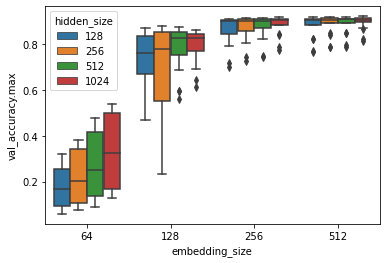

In [56]:
import seaborn as sns
embed_sizes = [64, 128, 256, 512,]
# df_64= df.loc[df["embedding_size"] == embed_sizes[0]]
# embed_sizes
sns.boxplot(data=df, x="embedding_size", y="val_accuracy.max", hue="hidden_size")

<AxesSubplot:xlabel='hidden_size', ylabel='val_accuracy.max'>

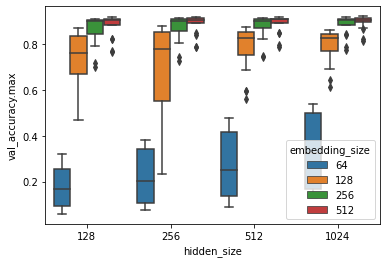

In [57]:
sns.boxplot(data=df, x="hidden_size", y="val_accuracy.max", hue="embedding_size")

<AxesSubplot:xlabel='hidden_size', ylabel='val_accuracy.max'>

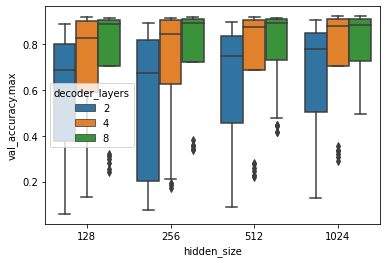

In [58]:
sns.boxplot(data=df, x="hidden_size", y="val_accuracy.max", hue="decoder_layers")

<AxesSubplot:xlabel='embedding_size', ylabel='val_accuracy.max'>

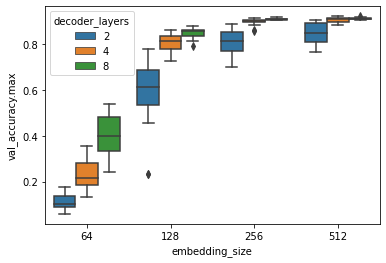

In [59]:
sns.boxplot(data=df, x="embedding_size", y="val_accuracy.max", hue="decoder_layers")

<AxesSubplot:xlabel='embedding_size', ylabel='val_accuracy.max'>

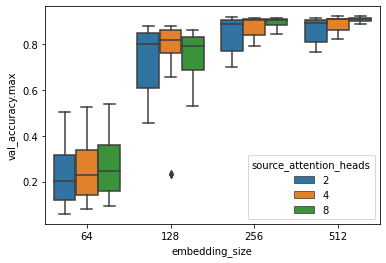

In [60]:
sns.boxplot(data=df, x="embedding_size", y="val_accuracy.max", hue="source_attention_heads")

<AxesSubplot:xlabel='hidden_size', ylabel='val_accuracy.max'>

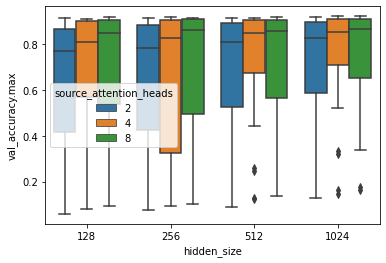

In [61]:
sns.boxplot(data=df, x="hidden_size", y="val_accuracy.max", hue="source_attention_heads")

<AxesSubplot:xlabel='hidden_size', ylabel='val_accuracy.max'>

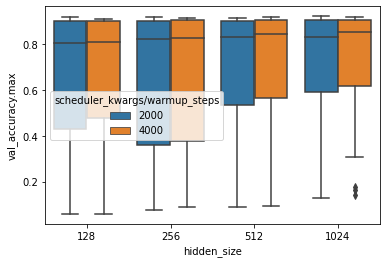

In [62]:
sns.boxplot(data=df, x="hidden_size", y="val_accuracy.max", hue="scheduler_kwargs/warmup_steps")

<AxesSubplot:xlabel='hidden_size', ylabel='val_accuracy.max'>

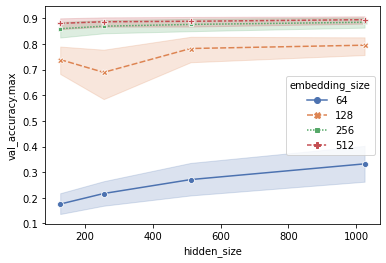

In [63]:
sns.lineplot(data=df, x="hidden_size", y="val_accuracy.max", estimator="mean", palette="deep", hue="embedding_size", style="embedding_size", markers=True)

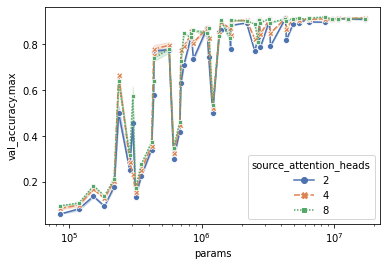

In [64]:
g = sns.lineplot(data=df, x="params", y="val_accuracy.max", estimator="mean", palette="deep", hue="source_attention_heads", style="source_attention_heads", markers=True)
g.set_xscale("log")

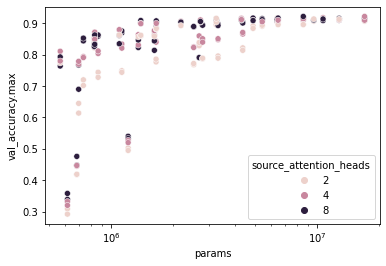

In [81]:
g = sns.scatterplot(
    data=df.loc[(df["params"] <= 50000000) & (df["params"] >= 500000)],
    x="params", y="val_accuracy.max", hue="source_attention_heads"
)
g.set_xscale("log")

In [66]:
ed_df = pd.read_csv("data/2017-ed-deu-sweep.csv")
ed_df["arch_name"] = "encoder-decoder"
# Ignore single attention head case
ed_df = ed_df.loc[df["source_attention_heads"] > 1]
ed_df["params"] = ed_df.apply(compute_num_params, axis=1)
ed_df.sort_values(by="val_accuracy.max", ascending=False).head(10)

,Name,val_accuracy.max,hidden_size,decoder_layers,embedding_size,source_attention_heads,scheduler_kwargs/warmup_steps,State,Notes,User,...,start_idx,target_vocab_size,teacher_forcing,epoch,lr-Adam,train_loss,trainer/global_step,val_loss,arch_name,params
60,german-train-high,0.926,256,8,256,2,2000,finished,-,adamits,...,2,71,True,799,0.000316,0.746672,19999,0.840297,encoder-decoder,8584704
136,german-train-high,0.925,256,8,256,8,4000,finished,-,adamits,...,2,71,True,799,0.000447,0.744878,19999,0.834411,encoder-decoder,8584704
180,german-train-high,0.924,256,8,256,4,2000,finished,-,adamits,...,2,71,True,799,0.000316,0.744600,19999,0.843918,encoder-decoder,8584704
63,german-train-high,0.924,128,8,256,4,2000,finished,-,adamits,...,2,71,True,799,0.000316,0.746320,19999,0.823664,encoder-decoder,7534080
181,german-train-high,0.924,256,8,256,8,2000,finished,-,adamits,...,2,71,True,799,0.000316,0.743870,19999,0.827092,encoder-decoder,8584704
88,german-train-high,0.923,256,8,256,4,4000,finished,-,adamits,...,2,71,True,799,0.000447,0.746520,19999,0.825830,encoder-decoder,8584704
111,german-train-high,0.922,256,8,128,8,2000,finished,-,adamits,...,2,71,True,799,0.000316,0.746964,19999,0.823382,encoder-decoder,2721536
113,german-train-high,0.922,128,8,256,4,4000,finished,-,adamits,...,2,71,True,799,0.000447,0.746866,19999,0.832066,encoder-decoder,7534080
272,german-train-high,0.922,512,8,256,4,2000,finished,-,adamits,...,2,71,True,799,0.000316,0.744555,19999,0.833561,encoder-decoder,10685952
94,german-train-high,0.922,128,8,256,2,2000,finished,-,adamits,...,2,71,True,799,0.000316,0.748446,19999,0.840618,encoder-decoder,7534080


<AxesSubplot:xlabel='hidden_size', ylabel='val_accuracy.max'>

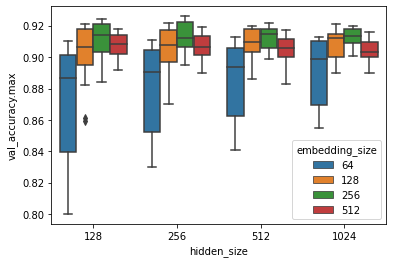

In [67]:
import seaborn as sns
sns.boxplot(data=ed_df, x="hidden_size", y="val_accuracy.max", hue="embedding_size")

<AxesSubplot:xlabel='hidden_size', ylabel='val_accuracy.max'>

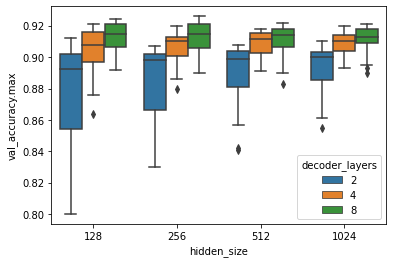

In [68]:
sns.boxplot(data=ed_df, x="hidden_size", y="val_accuracy.max", hue="decoder_layers")

<AxesSubplot:xlabel='embedding_size', ylabel='val_accuracy.max'>

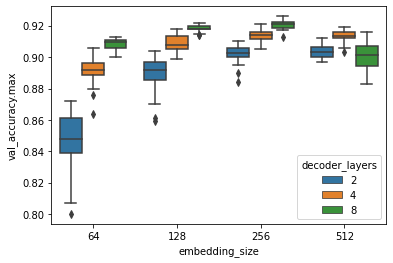

In [69]:
sns.boxplot(data=ed_df, x="embedding_size", y="val_accuracy.max", hue="decoder_layers")

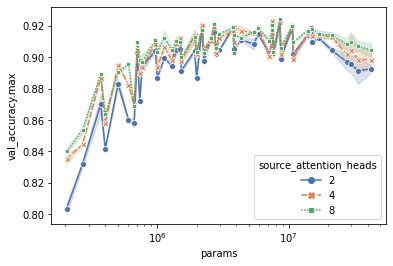

In [82]:
g = sns.lineplot(data=ed_df, x="params", y="val_accuracy.max", estimator="mean", palette="deep", hue="source_attention_heads", style="source_attention_heads", markers=True)
g.set_xscale("log")

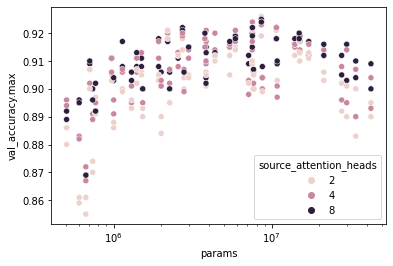

In [79]:
g = sns.scatterplot(
    data=ed_df.loc[(ed_df["params"] <= 50000000) & (ed_df["params"] >= 500000)],
    x="params", y="val_accuracy.max", hue="source_attention_heads"
)
g.set_xscale("log")

In [71]:
# cols = ["embedding_size", "source_attention_heads", "decoder_layers", "hidden_size", "scheduler_kwargs/warmup_steps"]
# df_all = df[cols].merge(ed_df[cols].drop_duplicates(), on=cols, 
#                    how="left", indicator=True)
# df[df_all["_merge"] == "left_only"][cols]

In [72]:
# with open("diff_script.sh", "w") as out:
#     print("#!/bin/bash", file=out)
#     print("", file=out)
#     print("TASK=sig-2017-inflection", file=out)
#     print("TARGET_COL=2", file=out)
#     print("FEATURES_COL=3", file=out)
#     print("train_filename=german-train-high", file=out)
#     print("dev_filename=german-dev", file=out)
#     print("", file=out)
#     print("ok")
#     for idx, row in df[df_all["_merge"] == "left_only"][cols].iterrows():
#         print(
#             "sbatch --export=ALL,TASK=${TASK},train_filename=${train_filename},dev_filename=${dev_filename},TARGET_COL=${TARGET_COL},FEATURES_COL=${FEATURES_COL},embedding_size=" + f"{row['embedding_size']},hidden_size={row['hidden_size']},num_layers={row['decoder_layers']},num_heads={row['source_attention_heads']},warmup={row['scheduler_kwargs/warmup_steps']} curc_exps/train_one_ed.sh",
#             file=out
#         )